### Importing Libraries

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from datetime import datetime
from sklearn.model_selection import GridSearchCV

### Loading Datasets

In [13]:
train_data = pd.read_csv('train.csv')
train_data.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [17]:
asset_data = pd.read_csv('asset_details.csv')
asset_data

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### EDA

In [15]:
train_data.describe()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,1.577120e+09,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,3.323350e+07,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,1.549011e+09,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,1.578372e+09,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,1.606198e+09,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.632182e+09,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [16]:
#Timestamp

totimestamp = lambda s: np.int32(time.mktime(datetime.strptime(s, "%d/%m/%Y").timetuple()))

In [18]:
btc = train_data[train_data["Asset_ID"]==1].set_index("timestamp")
eth = train_data[train_data["Asset_ID"]==6].set_index("timestamp")
bnb = train_data[train_data["Asset_ID"]==0].set_index("timestamp")
ada = train_data[train_data["Asset_ID"]==3].set_index("timestamp")

In [24]:
beg_btc = datetime.fromtimestamp(btc.index[0]).strftime("%A, %B, %d, %Y %T:%M:%S")
end_btc = datetime.fromtimestamp(btc.index[-1]).strftime("%A, %B, %d, %Y %T:%M:%S")

beg_eth = datetime.fromtimestamp(eth.index[0]).strftime("%A, %B, %d, %Y %T:%M:%S")
end_eth = datetime.fromtimestamp(eth.index[-1]).strftime("%A, %B, %d, %Y %T:%M:%S")

beg_bnb = datetime.fromtimestamp(bnb.index[0]).strftime("%A, %B, %d, %Y %T:%M:%S")
end_bnb = datetime.fromtimestamp(bnb.index[-1]).strftime("%A, %B, %d, %Y %T:%M:%S")

beg_ada = datetime.fromtimestamp(ada.index[0]).strftime("%A, %B, %d, %Y %T:%M:%S")
end_ada = datetime.fromtimestamp(ada.index[-1]).strftime("%A, %B, %d, %Y %T:%M:%S")

print('Bitcoin',beg_btc,'to',end_btc)
print('Ethereum',beg_eth,'to',end_eth)
print('Binance',beg_bnb,'to',end_bnb)
print('Cardano',beg_ada,'to',end_ada)

Bitcoin Sunday, December, 31, 2017 19:01:00:01:00 to Monday, September, 20, 2021 20:00:00:00:00
Ethereum Sunday, December, 31, 2017 19:01:00:01:00 to Monday, September, 20, 2021 20:00:00:00:00
Binance Sunday, December, 31, 2017 19:01:00:01:00 to Monday, September, 20, 2021 20:00:00:00:00
Cardano Tuesday, April, 17, 2018 05:11:00:11:00 to Monday, September, 20, 2021 20:00:00:00:00


### Heatmap for BTC

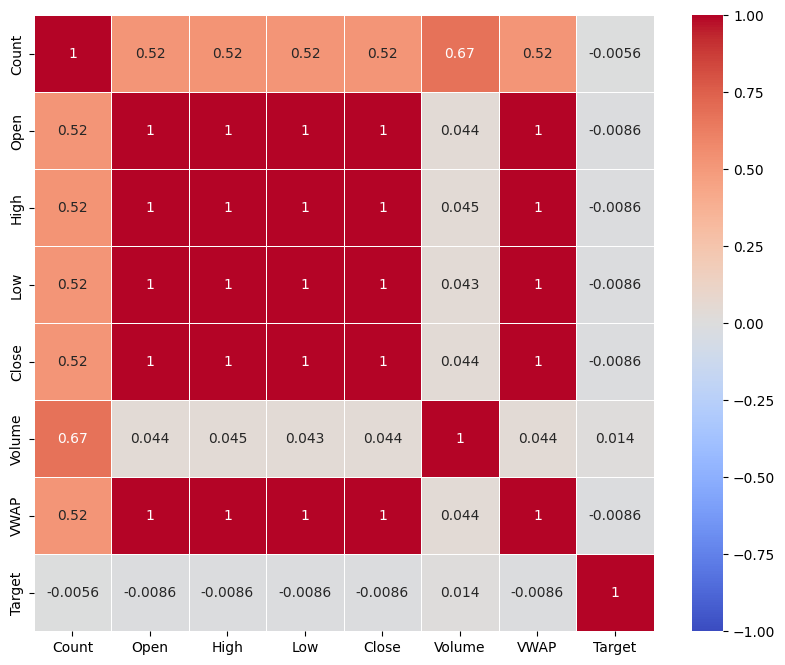

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(btc[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(),
           vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm',linewidth=0.4)
plt.show()

### Plot BTC, ETH

Text(0, 0.5, 'Ethereum')

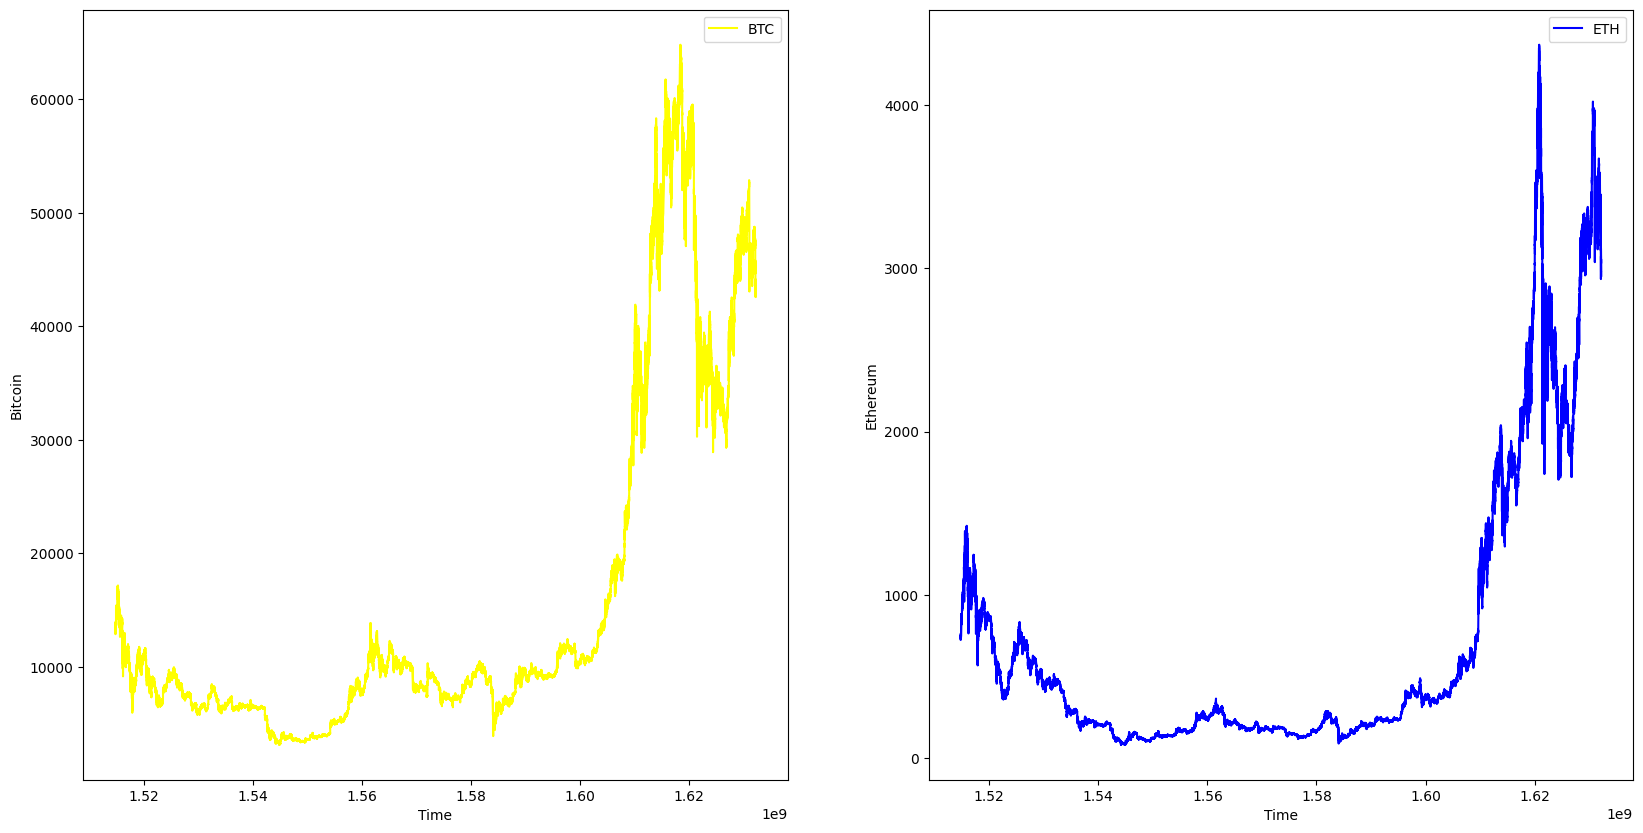

In [41]:
f = plt.figure(figsize=(20,10))

btc = btc.reindex(range(btc.index[0],btc.index[-1]+60,60),method='pad')
eth = eth.reindex(range(eth.index[0],eth.index[-1]+60,60),method='pad')

ax1 = f.add_subplot(121)
ax1.plot(btc['Close'], color='yellow', label='BTC')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')

ax2 = f.add_subplot(122)
ax2.plot(eth['Close'], color='blue', label='ETH')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ethereum')

### Plot BNB, ADA

Text(0, 0.5, 'Cardano')

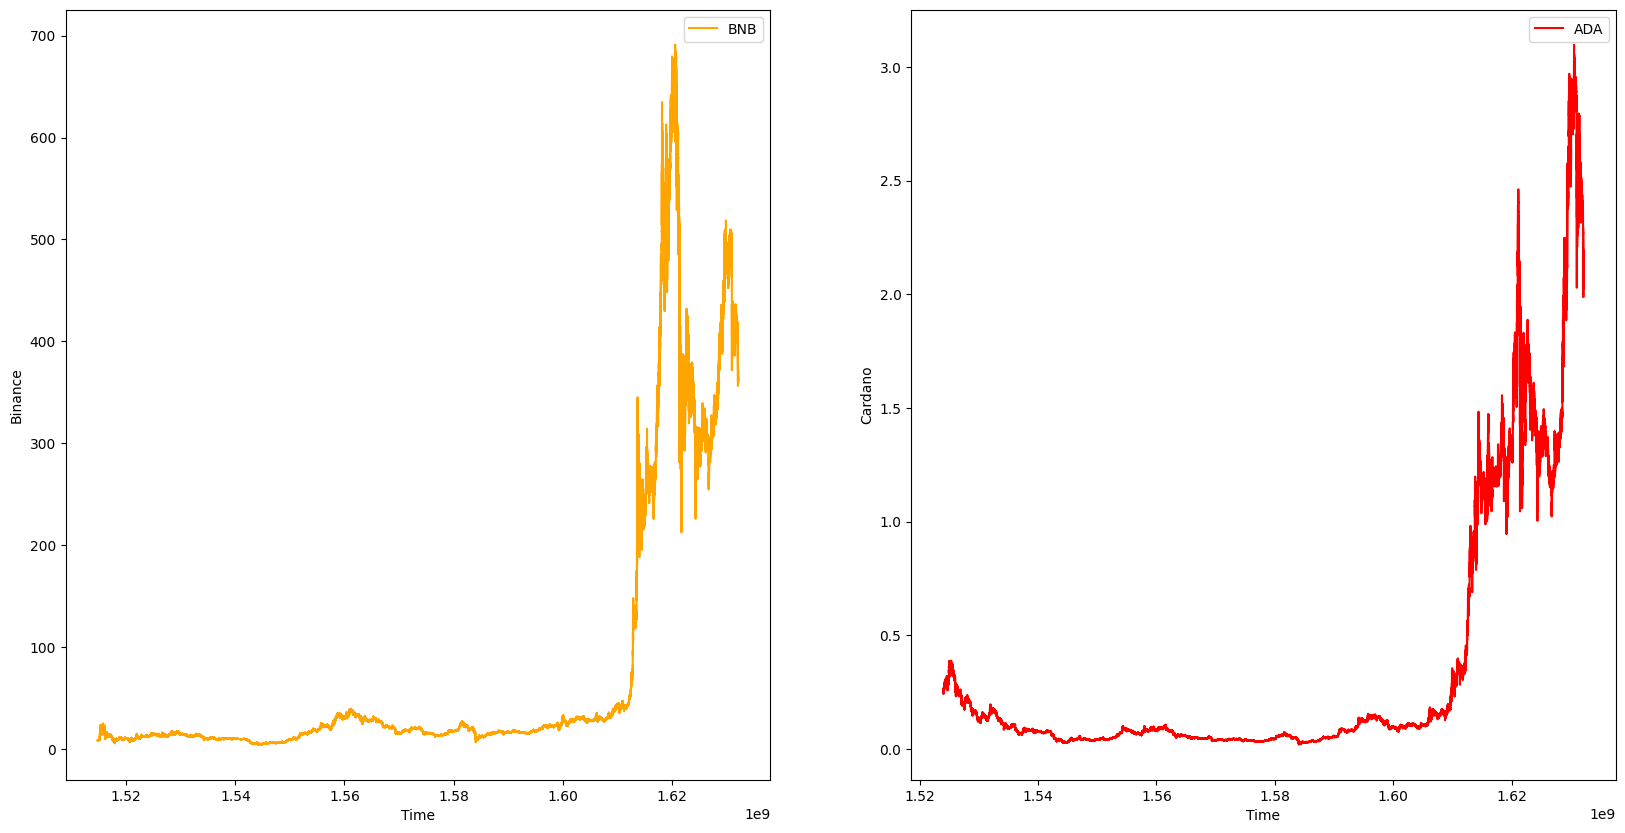

In [42]:
f = plt.figure(figsize=(20,10))

bnb = bnb.reindex(range(bnb.index[0],bnb.index[-1]+60,60),method='pad')
ada = ada.reindex(range(ada.index[0],ada.index[-1]+60,60),method='pad')

ax3 = f.add_subplot(121)
ax3.plot(bnb['Close'], color='orange', label='BNB')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Binance')

ax4 = f.add_subplot(122)
ax4.plot(ada['Close'], color='red', label='ADA')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Cardano')

### Heatmap of Coins

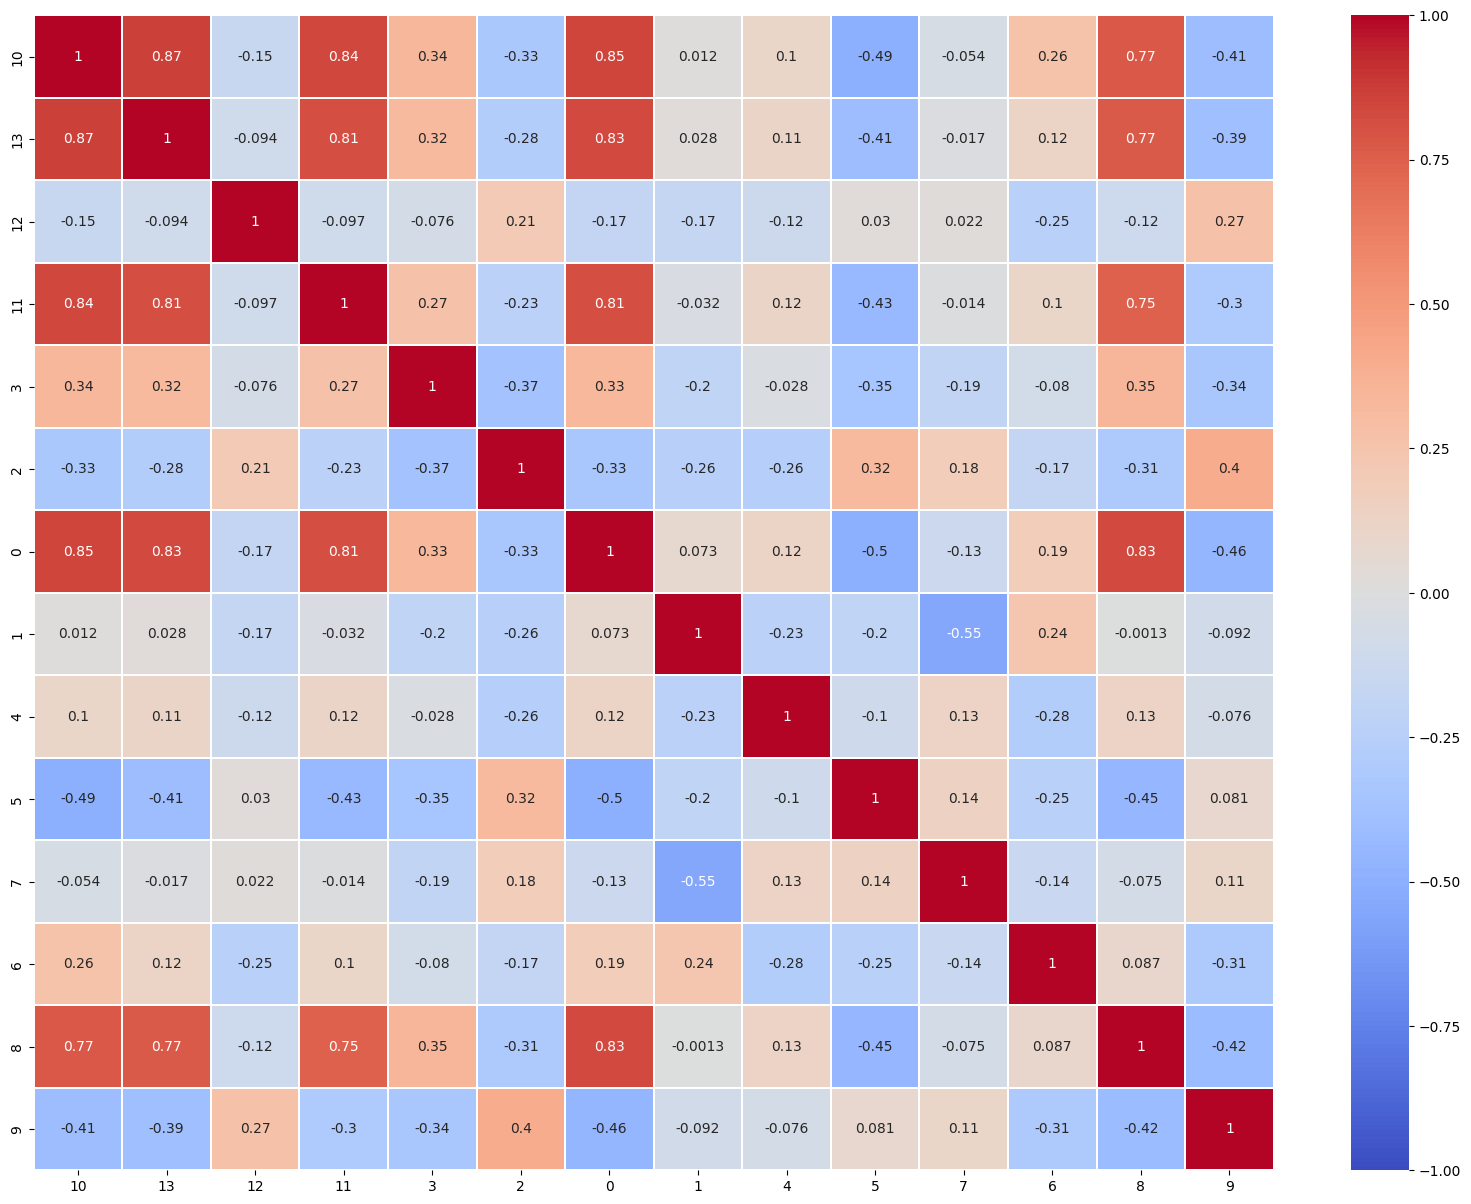

In [43]:
data = train_data[-10000:]
check = pd.DataFrame()
for i in data.Asset_ID.unique():
    check[i] = data[data.Asset_ID==i]['Target'].reset_index(drop=True)

plt.figure(figsize=(20,15))
sns.heatmap(check.dropna().corr(), vmin=-1.0, vmax=1.0, annot=True, cmap='coolwarm', linewidths=0.2)
plt.show()

### Feature Extraction

In [45]:
def hlco_ratio(data):
    return (data['High'] - data['Low'])/(data['Close'] - data['Open'])

def upper_shadow(data):
    return data['High'] - np.maximum(data['Close'], data['Open'])

def lower_shadow(data):
    return np.minimum(data['Close'], data['Open']) - data['Low']

def get_features(data):
    feature = data[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    feature['Upper_Shadow'] = upper_shadow(feature)
    feature['hlco_ratio'] = hlco_ratio(feature)
    feature['Lower_Shadow'] = lower_shadow(feature)
    return feature

### Model Building

In [50]:
def xy_model(train_data, asset_id):
    data = train_data[train_data["Asset_ID"]==asset_id]
    
    data =  data.sample(frac=0.2)
    data_process = get_features(data)
    data_process['y'] = data['Target']
    data_process.replace([np.inf, -np.inf], np.nan, inplace=True)
    data_process = data_process.dropna(how="any")
    
    X = data_process.drop("y",axis=1)
    y = data_process["y"]
    model = LGBMRegressor()
    model.fit(X, y)
    return X, y, model

Xs = {}
ys = {}
models = {}

for asset_id, asset_name in zip(asset_data['Asset_ID'], asset_data['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    X, y, model = xy_model(train_data, asset_id)
    try:
        Xs[asset_id], ys[asset_id], models[asset_id] = X, y, model
    except:
        Xs[asset_id], ys[asset_id], models[asset_id] = None, None, None

Training model for Bitcoin Cash     (ID=2 )
Training model for Binance Coin     (ID=0 )
Training model for Bitcoin          (ID=1 )
Training model for EOS.IO           (ID=5 )
Training model for Ethereum Classic (ID=7 )
Training model for Ethereum         (ID=6 )
Training model for Litecoin         (ID=9 )
Training model for Monero           (ID=11)
Training model for TRON             (ID=13)
Training model for Stellar          (ID=12)
Training model for Cardano          (ID=3 )
Training model for IOTA             (ID=8 )
Training model for Maker            (ID=10)
Training model for Dogecoin         (ID=4 )


### Hyperparameter Tuning

In [53]:
parameters = {'num_leaves': range(21,151,10),
             'learning_rate': [0.1, 0.2, 0.01, 0.06]}

new_models = {}
for asset_id, asset_name in zip(asset_data['Asset_ID'], asset_data['Asset_Name']):
    print("GridSearchCV for:"+asset_name)
    grid_search = GridSearchCV(
        estimator=xy_model(train_data, asset_id)[2],
        param_grid = parameters,
        n_jobs = -1,
        cv = 6,
        verbose = True)
    grid_search.fit(Xs[asset_id], ys[asset_id])
    new_models[asset_id] = grid_search.best_estimator_
    grid_search.best_estimator_

GridSearchCV for:Bitcoin Cash
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Binance Coin
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Bitcoin
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:EOS.IO
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Ethereum Classic
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Ethereum
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Litecoin
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Monero
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:TRON
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Stellar
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:Cardano
Fitting 6 folds for each of 52 candidates, totalling 312 fits
GridSearchCV for:IOTA
Fitti

In [54]:
for asset_id, asset_name in zip(asset_data['Asset_ID'], asset_data['Asset_Name']):
    print(f"Tuned model {asset_name:<1} (ID={asset_id:})")
    print(new_models[asset_id])

Tuned model Bitcoin Cash (ID=2)
LGBMRegressor(learning_rate=0.01, num_leaves=21)
Tuned model Binance Coin (ID=0)
LGBMRegressor(learning_rate=0.01, num_leaves=41)
Tuned model Bitcoin (ID=1)
LGBMRegressor(learning_rate=0.06, num_leaves=61)
Tuned model EOS.IO (ID=5)
LGBMRegressor(learning_rate=0.01, num_leaves=51)
Tuned model Ethereum Classic (ID=7)
LGBMRegressor(learning_rate=0.01)
Tuned model Ethereum (ID=6)
LGBMRegressor(learning_rate=0.06, num_leaves=51)
Tuned model Litecoin (ID=9)
LGBMRegressor(learning_rate=0.06, num_leaves=51)
Tuned model Monero (ID=11)
LGBMRegressor(num_leaves=21)
Tuned model TRON (ID=13)
LGBMRegressor(learning_rate=0.01, num_leaves=81)
Tuned model Stellar (ID=12)
LGBMRegressor(learning_rate=0.06)
Tuned model Cardano (ID=3)
LGBMRegressor(learning_rate=0.01, num_leaves=81)
Tuned model IOTA (ID=8)
LGBMRegressor(learning_rate=0.06, num_leaves=21)
Tuned model Maker (ID=10)
LGBMRegressor(learning_rate=0.01, num_leaves=21)
Tuned model Dogecoin (ID=4)
LGBMRegressor(learn